# DS 2 - Homework 2 - Němec, Kovalčíková

## 1) Import a Data

Nejprve importujeme všechny potřebné knihovny a funkce a nastavíme seed (ponechali jsme defaultní z templatu):

In [1]:
import os
import sys
from typing import Dict, List, Optional, Sequence, TextIO
import numpy as np
import pandas as pd
import urllib.request
import pickle
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")

from DS_2_2024_HW2_efficient_net import EfficientNet

tf.keras.utils.set_random_seed(16)

Nyní definujeme rozměry našich budoucích vstupů a funkci "parse", která slouží k prvnímu zprocesování dat po jejich načtení. Funkce převede obrázky kódované jako jpeg (potažmo png pro masku) na data typu float32, k nimž následně vytvoří dictionary tak, abychom se mohli odkazovat na "image", "mask" a také na "label" (int64 dtype).
Načteme trénovací a validační data a zprocesujeme je.

In [2]:
# Výška, šířka a počet channelů
H: int = 224
W: int = 224
C: int = 3
LABELS: int = 34
    
# Declare functions
def parse(example) -> Dict[str, tf.Tensor]:
    example = tf.io.parse_single_example(example, {
        "image": tf.io.FixedLenFeature([], tf.string),
        "mask": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)})
    example["image"] = tf.image.convert_image_dtype(tf.image.decode_jpeg(example["image"], channels=3), tf.float32)
    example["mask"] = tf.image.convert_image_dtype(tf.image.decode_png(example["mask"], channels=1), tf.float32)
    return example

# Načtení dat
train = tf.data.TFRecordDataset("hw2_trainsample.tfrecord")
dev = tf.data.TFRecordDataset("hw2_devsample.tfrecord")

# Zprocesování dat
train = train.map(parse)
dev = dev.map(parse)

## 2) Data explorace

Nyní provedeme exploraci dat. Níže se díváme na počet pozorování v našem train samplu a dev (validačním) samplu.

In [3]:
num_observations_train = sum(1 for _ in train)
print(num_observations_train)

num_observations_dev = sum(1 for _ in dev)
print(num_observations_dev)

2142
306


Nyní se podíváme, jak vlastně naše data vypadají. Vykreslíme například hned prvních pět obrázků z trénovací sady.

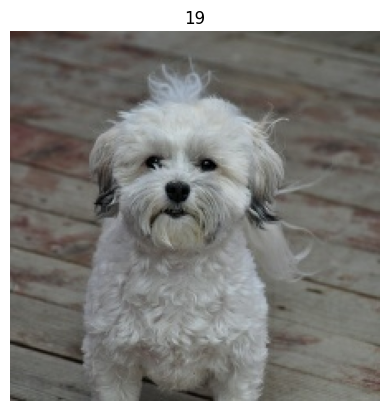

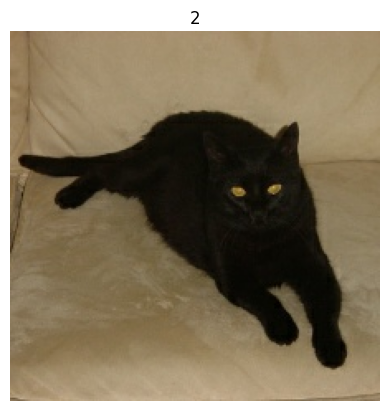

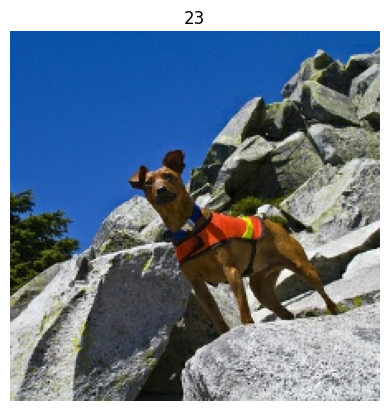

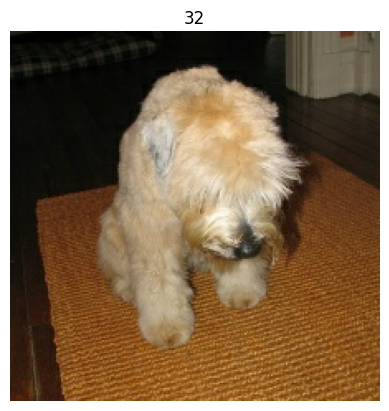

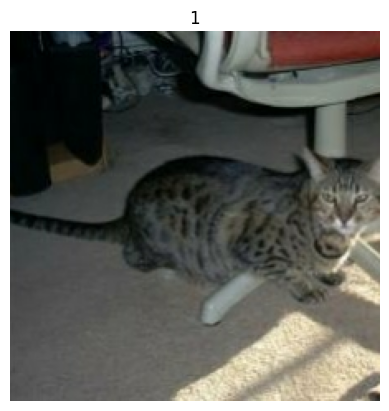

In [4]:
for i in range(5):
    plt.imshow(next(iter(train.skip(i)))["image"])
    plt.axis('off')  # Turn off axis
    plt.title(int(next(iter(train.skip(i)))["label"]))
    plt.show()

## 3) Augmentace a Batching

V této části zadefinujeme funkce pro data augmentation a augmentaci provedeme. Volíme náhodnou změnu kvality obrázku, náhodné přetočení zleva doprava, náhodné přetočení vzhůru nohama a náhodnou rotaci o 90 stupňů. Augmentaci aplikujeme na náš trénovací i validační dataset.

In [5]:
def augment_train(input):
    image = input['image']
    label = input['label']
    
    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image, label

def augment_dev(input):
    image = input['image']
    label = input['label']
    
    image = tf.image.random_jpeg_quality(image,80,100)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    return image, label

# Now we apply augmentation using .map()
train = train.map(augment_train)
dev = dev.map(augment_dev)

Níže můžeme vidět, jak augmentace pozměnila naše obrázky.

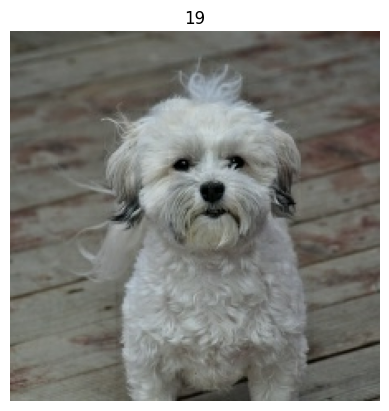

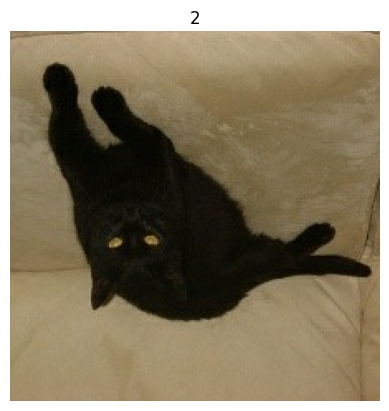

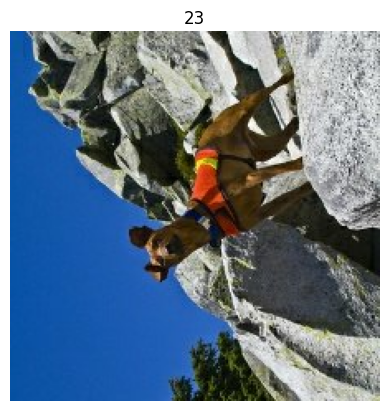

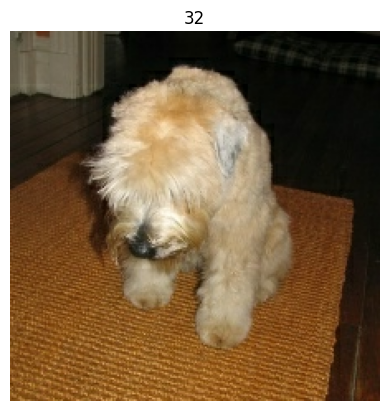

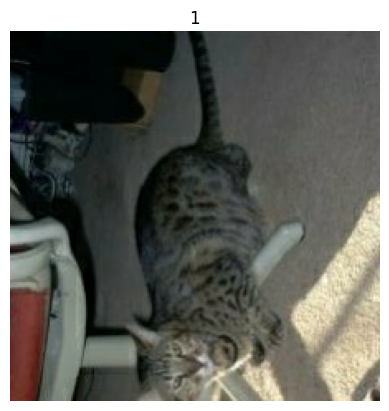

In [6]:
for img, lbl in train.take(5):
        img_np = img.numpy()
        plt.figure()
        plt.imshow(img_np)
        plt.title(lbl.numpy())
        plt.axis('off')
        plt.show()

Nakonec rozdělíme naše data do batchů o velikosti 32. (Až pozdě jsme si všimli, že jsme volili batch size 32 namísto 34, ačkoliv 32 není dělitelem počtů pozorování uvedených výše, což pravděpodobně znamená, že malé množství obrázků nebylo v modelu použito).

In [7]:
train = train.batch(32)
dev = dev.batch(32)

## 4) Modelování

Nyní postavíme náš model. Začneme tím, že si zadefinujeme base_model jako EfficientNet model s příslušnými zvolenými parametry. Následně zmrazíme všechny layery tohoto modelu až na posledních 17 odpovídajících poslednímu sedmému bloku a posledním top layers. Pro tuto volbu jsme se rozhodli na základě následující úvahy:

Jelikož první layery odpovídají spíše obecnějším charakteristikám, jako jsou hrany, rohy, atd., ponecháme tyto layery zmražené, neboť se domníváme, že tyto váhy jsou již velmi dobře natrénované na ImageNetu. Naopak poslední "task-specific" layery necháme rozmražené, abychom je mohli aktualizovat na náš specifický problém.

Zadefinujeme regularizaci a stavíme model. Model nejprve prožene inputy EfficientNetem, následně přes dva fully-connected layery s dropoutem a regularizací (+ popř. batch-normalizací) a nakonec vydá output. Jako nejlepší aktivační funkce se v hidden layers jevil tanh. V outputové vrstvě nebylo moc o čem rozmýšlet, neboť máme vícekategoriální problém, a proto byl softmax jasnou volbou.

Model kompilujeme. Jako optimizer volíme Adam, neboť se jevil jako nejoptimálnější. Loss a metriku volíme na základě zadání.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet (Functional)   [(None, 1280),            4049564   
                              (None, 7, 7, 1280),                
                              (None, 14, 14, 112),               
                              (None, 28, 28, 40),                
                              (None, 56, 56, 24),                
                              (None, 112, 112, 16)]              
                                                                 
 dense (Dense)               (None, 136)               174216    
                                                                 
 dropout (Dropout)           (None, 136)               0         
                                                             

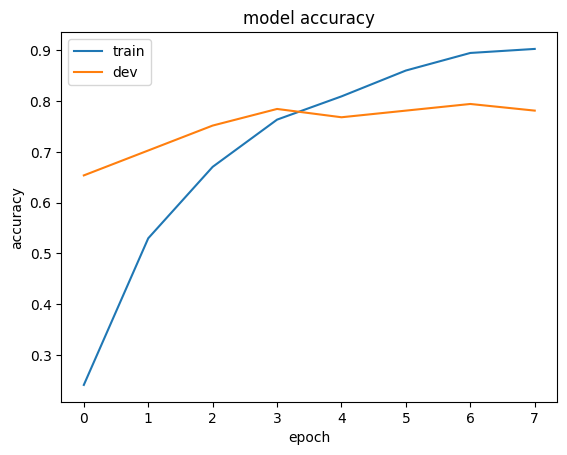

In [8]:
base_model = EfficientNet(
    width_coefficient = 1,
    depth_coefficient = 1,
    default_resolution = 224,
    weights = "efficientnet.h5",
    include_top = False
)

for layer in base_model.layers:
   layer.trainable = False

for layer in base_model.layers[-17:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True    

reg = tf.keras.regularizers.L1L2(l2=0.001)

# Input:
inputs = tf.keras.layers.Input([H, W, C])

# EfficientNet:
x = base_model(inputs)[0]

# Fully connected layer with dropout and L2 regularization:
x = tf.keras.layers.Dense(136, activation='tanh', kernel_regularizer=reg)(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)

# Fully connected layer with dropout and L2 regularization:
x = tf.keras.layers.Dense(68, activation='tanh', kernel_regularizer=reg)(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)
# Outputs:
outputs = tf.keras.layers.Dense(LABELS, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)
model.summary()

epochs = 8

early_call = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', patience=3, restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/HW2')

fit = model.fit(train,
          epochs=epochs,
          validation_data=dev,
          callbacks=[early_call])

def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "dev"], loc="upper left")
    plt.show()

plot_hist(fit)

## 5) Predikce na testu

Na závěr provádíme predikci na testovacím datasetu pomocí kódu z tamplate souboru. Výstup není rovnou vhodný k odevzdání, neboť excel např. 128,0 bere jako číslo 128. To je potřeba upravit ručně před samotným odevzdáním.

In [9]:
# Load test dataset stored as pickled list.
with open('hw2_outofsample.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Produce dataset from list
test = tf.data.Dataset.from_tensor_slices(test)

# Apply batching also to 'test'
test = test.batch(150) # 150 observations in test

# Predict
test_prediction_prob = model.predict(test)
test_prediction = [
    np.argmax(probs) for probs in test_prediction_prob
]

df = pd.DataFrame({'ID': range(len(test_prediction)), 'TARGET': test_prediction})
df.to_csv('hw2_outofsample_prediction.csv', index=False, header=True)